In [1]:
# Week 8: Algorithmic Trading and Backtesting
# Strategy: Momentum (SMA Crossover) with backtesting vs SPY and QQQ

# ----------------------------
# STEP 1: Import Dependencies
# ----------------------------
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Set plotting style
plt.style.use("seaborn-v0_8-darkgrid")

# Ensure outputs folder exists
os.makedirs("outputs", exist_ok=True)

In [2]:
# ----------------------------
# STEP 2: Download Price Data
# ----------------------------
tickers = ['AAPL', 'MSFT', 'NVDA']
benchmark_tickers = ['SPY', 'QQQ']
start_date = '2019-01-01'
end_date = '2024-10-01'

# Download all tickers at once with auto-adjusted prices
all_tickers = tickers + benchmark_tickers
data = yf.download(all_tickers, start=start_date, end=end_date, progress=False)

# Check column format
if isinstance(data.columns, pd.MultiIndex):
    close_prices = data['Close']
else:
    close_prices = data

# Drop rows with any NaNs
close_prices = close_prices.dropna()

/var/folders/zz/y2_h9x0s2378k58hfr7vvwmh0000gn/T/ipykernel_83223/2798620836.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(all_tickers, start=start_date, end=end_date, progress=False)


In [3]:
# ----------------------------
# STEP 3: Calculate Returns
# ----------------------------
daily_returns = close_prices.pct_change().dropna()
log_returns = np.log(close_prices / close_prices.shift(1)).dropna()

# Save for inspection
close_prices.to_csv("outputs/close_prices.csv")
daily_returns.to_csv("outputs/daily_returns.csv")
log_returns.to_csv("outputs/log_returns.csv")

In [4]:
# ----------------------------
# STEP 4: Simple Trading Strategy (Momentum)
# ----------------------------
# Strategy: Buy if yesterday's return was positive
strategy_signal = (daily_returns[tickers] > 0).astype(int)
strategy_returns = strategy_signal.shift(1) * daily_returns[tickers]
strategy_cum_returns = (1 + strategy_returns).cumprod()

# Equal weight portfolio
equal_weight_returns = daily_returns[tickers].mean(axis=1)
equal_weight_cum = (1 + equal_weight_returns).cumprod()

# Benchmarks
spy_cum = (1 + daily_returns['SPY']).cumprod()
qqq_cum = (1 + daily_returns['QQQ']).cumprod()

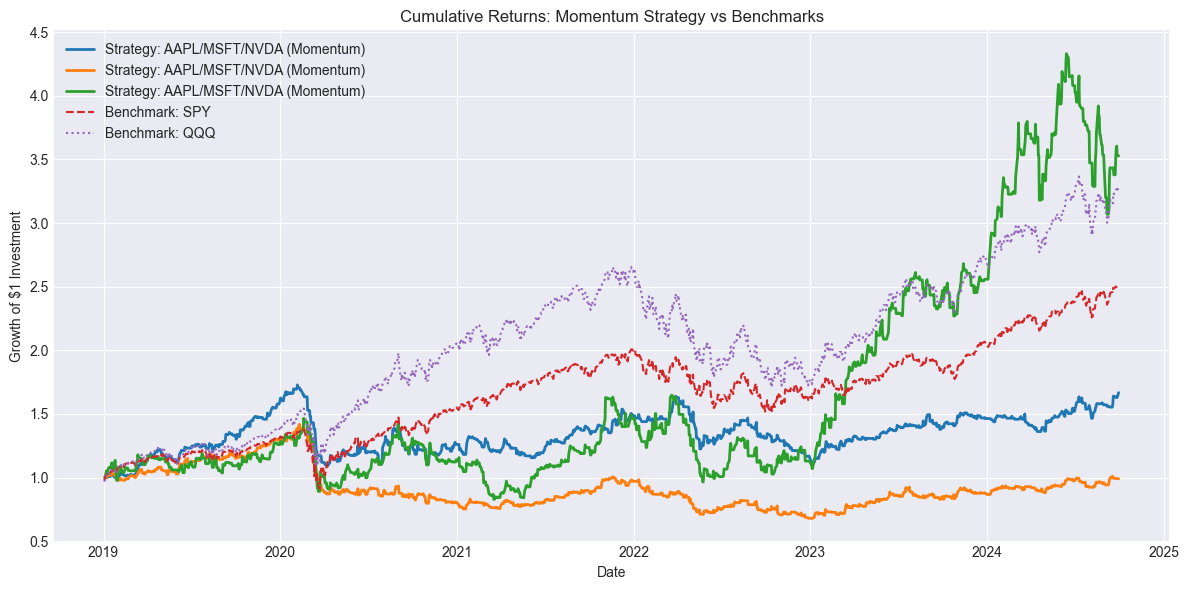

In [5]:
# ----------------------------
# STEP 5: Plot Results
# ----------------------------
plt.figure(figsize=(12, 6))
plt.plot(strategy_cum_returns, label="Strategy: AAPL/MSFT/NVDA (Momentum)", linewidth=2)
plt.plot(spy_cum, label="Benchmark: SPY", linestyle='--')
plt.plot(qqq_cum, label="Benchmark: QQQ", linestyle=':')
plt.legend()
plt.title("Cumulative Returns: Momentum Strategy vs Benchmarks")
plt.xlabel("Date")
plt.ylabel("Growth of $1 Investment")
plt.tight_layout()
plt.savefig("outputs/momentum_vs_benchmark.png")
plt.show()

In [6]:
# ----------------------------
# STEP 6: Performance Metrics
# ----------------------------
def performance_summary(returns, name="Portfolio"):
    summary = {
        'Cumulative Return': (returns + 1).prod() - 1,
        'Annualized Return': (1 + returns.mean()) ** 252 - 1,
        'Annualized Volatility': returns.std() * np.sqrt(252),
        'Sharpe Ratio': (returns.mean() / returns.std()) * np.sqrt(252)
    }
    return pd.Series(summary, name=name)

# Compare performance
summary_df = pd.DataFrame({
    'Momentum Strategy': performance_summary(strategy_returns.mean(axis=1)),
    'Equal Weight Portfolio': performance_summary(equal_weight_returns),
    'SPY': performance_summary(daily_returns['SPY']),
    'QQQ': performance_summary(daily_returns['QQQ'])
}).T

print(summary_df.round(4))
summary_df.to_csv("outputs/performance_summary.csv")

                        Cumulative Return  Annualized Return  \
Momentum Strategy                  0.9417             0.1488   
Equal Weight Portfolio            10.2386             0.6121   
SPY                                1.5120             0.1983   
QQQ                                2.2708             0.2674   

                        Annualized Volatility  Sharpe Ratio  
Momentum Strategy                      0.2126        0.6527  
Equal Weight Portfolio                 0.3337        1.4323  
SPY                                    0.2010        0.9004  
QQQ                                    0.2460        0.9638  


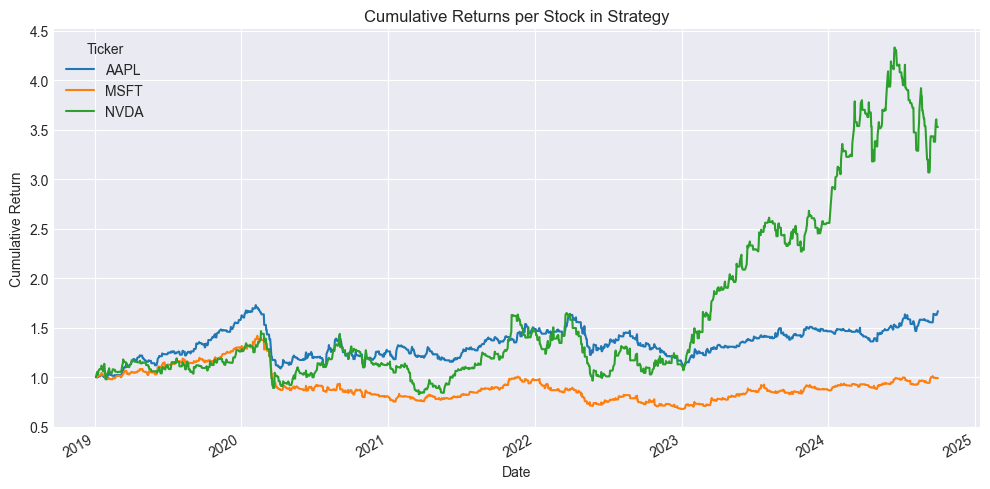

In [7]:
# ----------------------------
# STEP 7: Save Strategy Chart
# ----------------------------
strategy_cum_returns.plot(figsize=(10, 5), title="Cumulative Returns per Stock in Strategy")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.tight_layout()
plt.savefig("outputs/strategy_individual_returns.png")
plt.show()